In [1]:
from src import create_simple_plot_with_tables, BS468ReferenceResponse, plot_bs468_response_with_tables, weighting_filter_response
from src import verify_exact_values, plot_accurate_response, generate_calibration_table, export_for_filter_design

import numpy as np
import matplotlib.pyplot as plt

# Введение

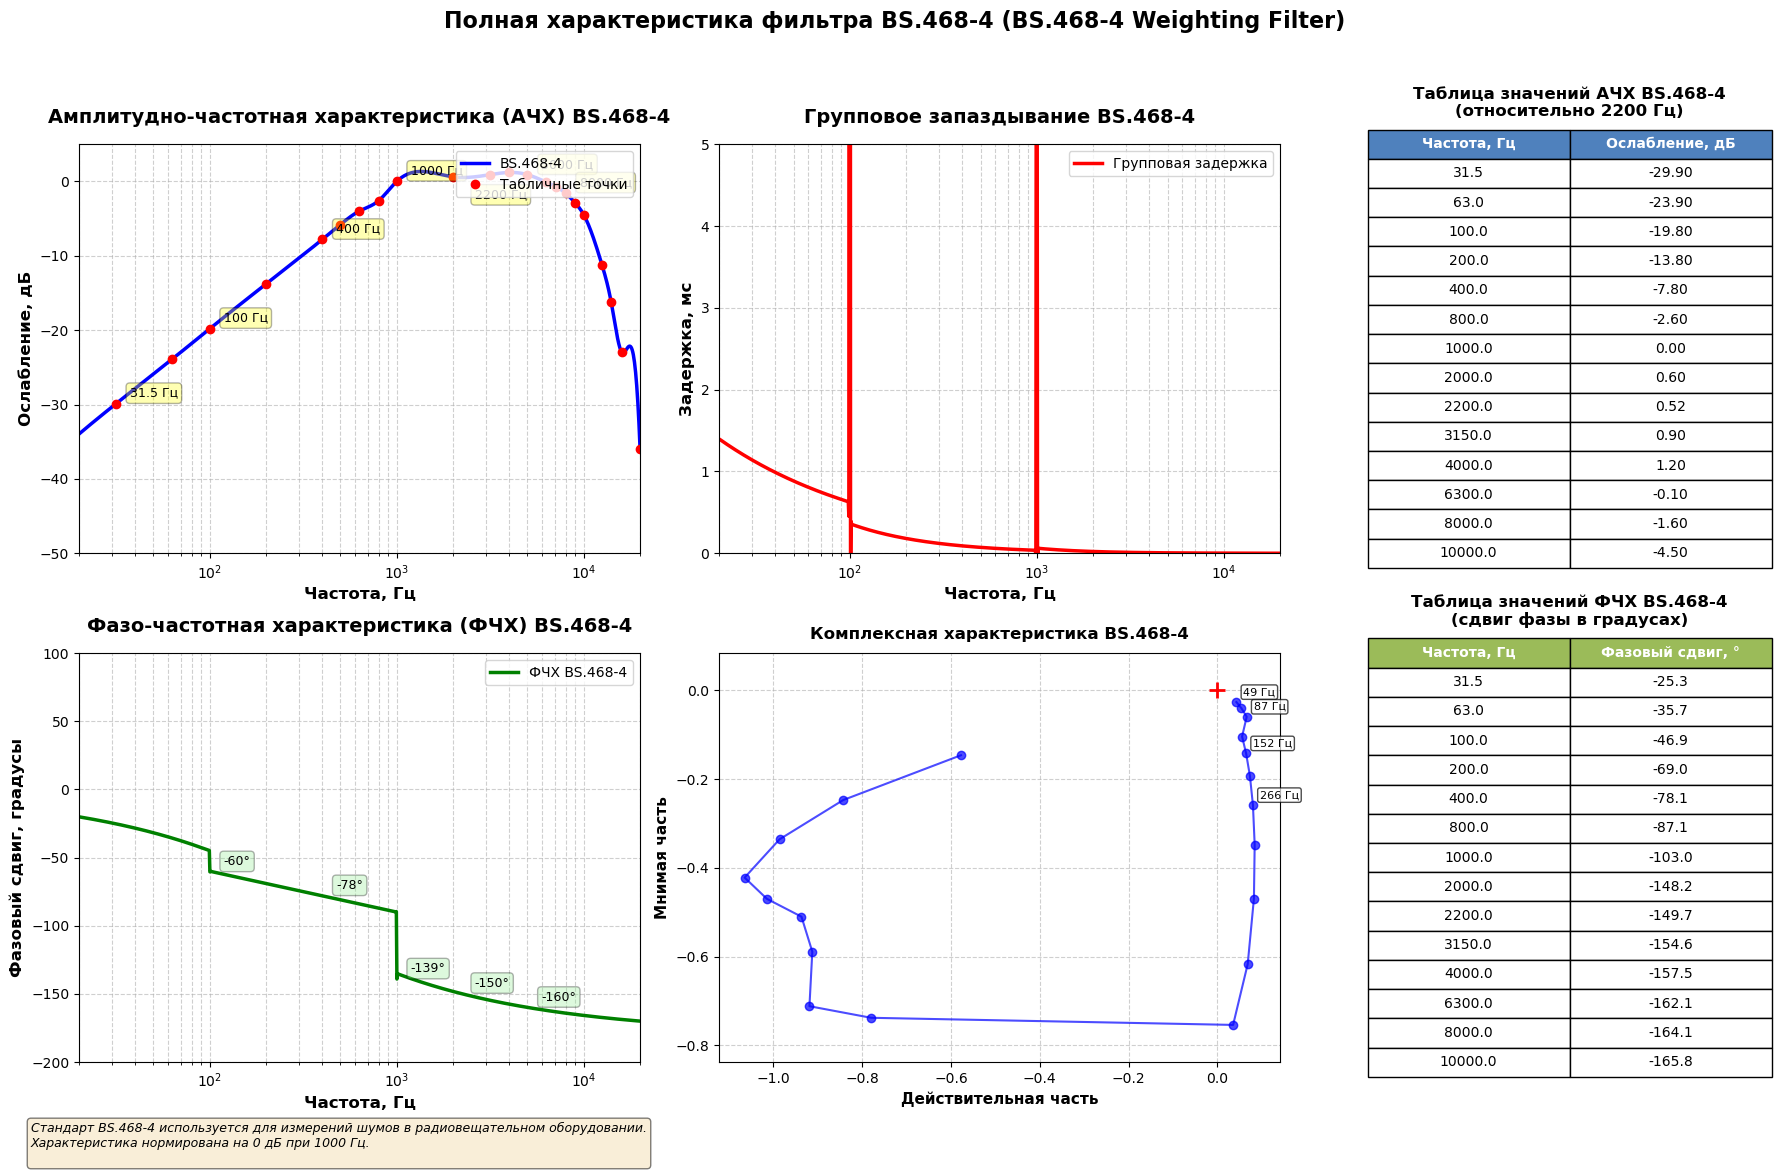


ТАБЛИЧНЫЕ ЗНАЧЕНИЯ ХАРАКТЕРИСТИК BS.468-4
Частота (Гц)    АЧХ (дБ)        ФЧХ (°)         Задержка (мс)  
--------------------------------------------------------------------------------
31.5            -29.90          -25.3           0.000          
63.0            -23.90          -35.7           0.877          
100.0           -19.80          -46.9           0.675          
200.0           -13.80          -69.0           0.289          
400.0           -7.80           -78.1           0.084          
800.0           -2.60           -87.1           0.116          
1000.0          0.00            -103.0          0.141          
2000.0          0.60            -148.2          0.108          
2200.0          0.52            -149.7          0.016          
3150.0          0.90            -154.6          0.012          
4000.0          1.20            -157.5          0.007          
6300.0          -0.10           -162.1          0.005          
8000.0          -1.60           -164.1      

In [5]:
#plot = create_simple_plot_with_tables()
plot_bs468_response_with_tables()

# Построение модели

## Подготовка данных

### АЧХ и ФЧХ фильтра BS.468-4

ТОЧНАЯ ХАРАКТЕРИСТИКА BS.468-4 НА ОСНОВЕ ТАБЛИЧНЫХ ДАННЫХ
Опорная частота: 1000 Гц = 0 дБ
Тип интерполяции: Кубические сплайны в логарифмической шкале
ТОЧНАЯ ПРОВЕРКА ТАБЛИЧНЫХ ЗНАЧЕНИЙ BS.468-4
Частота, Гц Табличное, дБ   Расчетное, дБ   Ошибка, дБ  
--------------------------------------------------------------------------------
31.5       -29.9           -29.900         0.000        ✓
63.0       -23.9           -23.900         0.000        ✓
100.0      -19.8           -19.800         0.000        ✓
200.0      -13.8           -13.800         0.000        ✓
400.0      -7.8            -7.800          0.000        ✓
500.0      -5.8            -5.800          0.000        ✓
630.0      -4.0            -4.000          0.000        ✓
800.0      -2.6            -2.600          0.000        ✓
1000.0     0.0             0.000           0.000        ✓
2000.0     0.6             0.600           0.000        ✓
3150.0     0.9             0.900           0.000        ✓
4000.0     1.2             1.

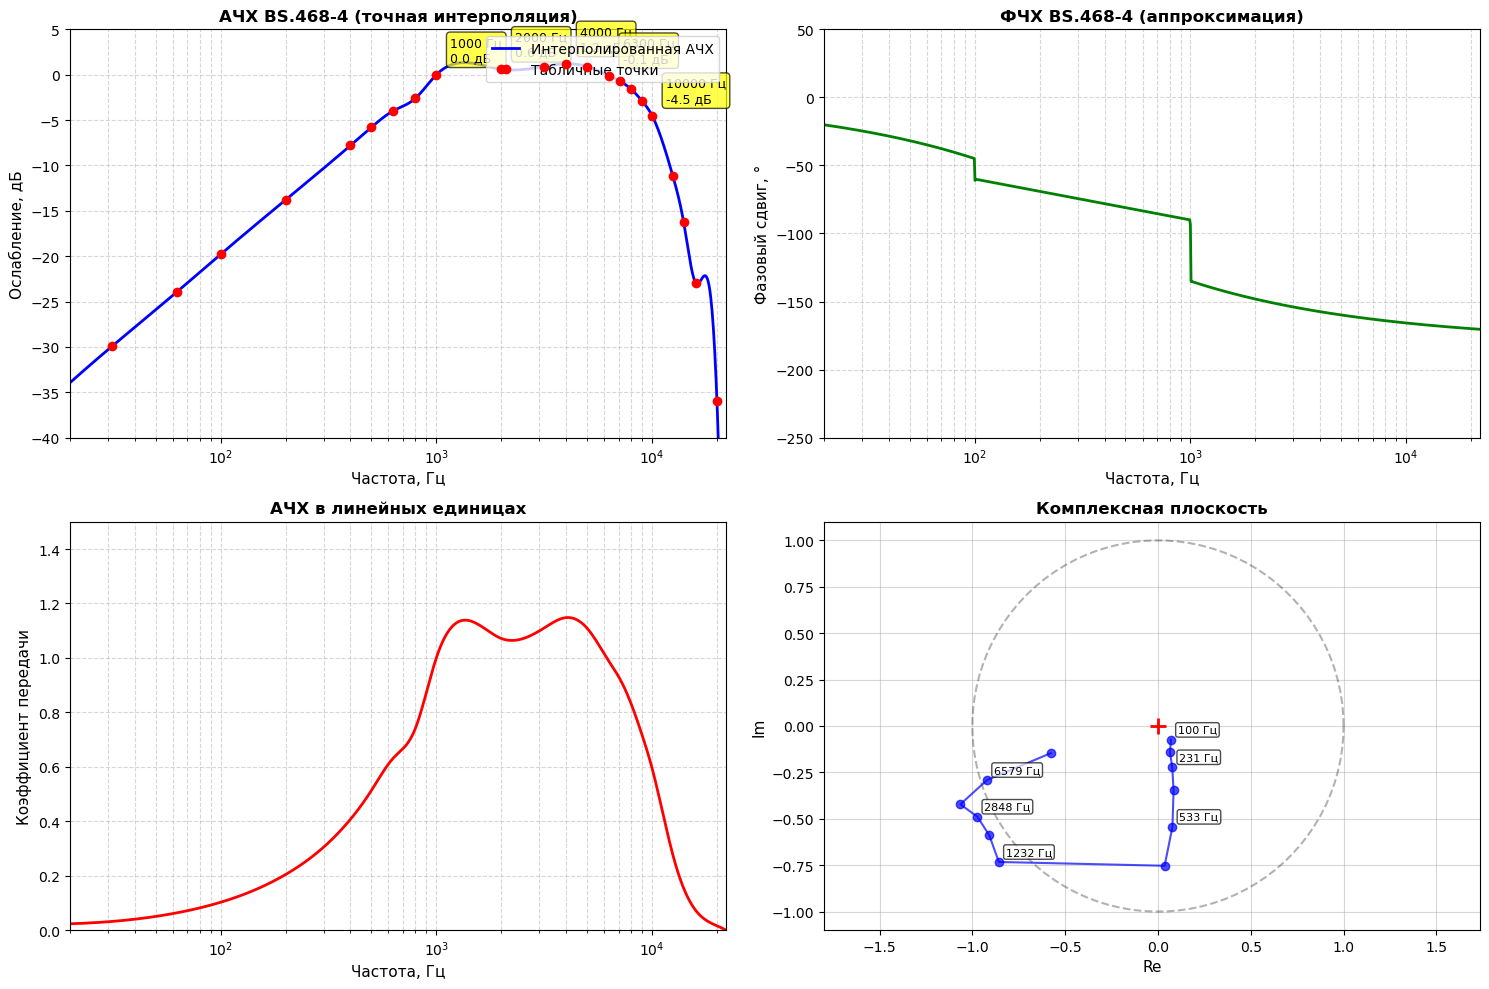


КАЛИБРОВОЧНАЯ ТАБЛИЦА BS.468-4
Частота  АЧХ (дБ)     Коэф. передачи     ФЧХ (°)      В таблице 
----------------------------------------------------------------------------------------------------
31.5     -29.900      0.031989           -25.3        Да         
63.0     -23.900      0.063826           -35.7        Да         
100.0    -19.800      0.102329           -46.9        Да         
200.0    -13.800      0.204174           -69.0        Да         
400.0    -7.800       0.407380           -78.1        Да         
500.0    -5.800       0.512861           -81.0        Да         
630.0    -4.000       0.630957           -84.0        Да         
800.0    -2.600       0.741310           -87.1        Да         
1000.0   0.000        1.000000           -103.0       Да         ← опорная
1500.0   1.230        1.130596           -143.3                  
2000.0   0.600        1.071519           -148.2       Да         ← ключевая
2500.0   0.566        1.070050           -151.5          

In [2]:
print("ТОЧНАЯ ХАРАКТЕРИСТИКА BS.468-4 НА ОСНОВЕ ТАБЛИЧНЫХ ДАННЫХ")
print("=" * 70)
print("Опорная частота: 1000 Гц = 0 дБ")
print("Тип интерполяции: Кубические сплайны в логарифмической шкале")
print("=" * 70)
    
# Точная проверка
bs468 = verify_exact_values()
    
# Графики
bs468 = plot_accurate_response()
    
# Калибровочная таблица
bs468 = generate_calibration_table()
    
# Экспорт для проектирования
bs468, freqs, mag_db, phase_deg, complex_resp = export_for_filter_design()
    
# Дополнительная информация
print("\n" + "="*70)
print("ИНФОРМАЦИЯ ДЛЯ ПРОЕКТИРОВАНИЯ:")
print("="*70)
    
# Ключевые значения для проектирования КИХ-фильтра
design_freqs = [100, 400, 1000, 2000, 4000, 6300, 8000, 10000]
    
print("Ключевые точки для проектирования фильтра:")
for f in design_freqs:
    mag = bs468.get_magnitude_db(f)
    phase = bs468.get_phase_deg(f)
    mag_lin = 10 ** (mag / 20)
        
    print(f"  {f:5} Гц: АЧХ = {mag:6.2f} дБ (K={mag_lin:.4f}), "
              f"ФЧХ = {phase:7.1f}°")
    
print("\nДля проектирования КИХ-фильтра методом частотной выборки:")
print("1. Используйте массив complex_response")
print("2. Примените обратное ДПФ")
print("3. Используйте окно (Хэмминга, Ханна)")
    


In [4]:
# Пример сравнения
freqs = np.logspace(1, 4, 1000)  # 10 Гц - 10 кГц

p53_response = weighting_filter_response('p53', freqs)
bs468_response = weighting_filter_response('bs468', freqs)

# Найдем коэффициенты передачи на 1 кГц для сравнения
print(f"На 1000 Гц:")
print(f"  P.53: {p53_response[freqs==1000][0]:.2f} дБ (Ku={10**(p53_response[freqs==1000][0]/20):.3f})")
print(f"  BS.468-4: {bs468_response[freqs==1000][0]:.2f} дБ (Ku={10**(bs468_response[freqs==1000][0]/20):.3f})")

На 1000 Гц:
  P.53: 0.20 дБ (Ku=1.023)
  BS.468-4: -3.60 дБ (Ku=0.661)


In [3]:
# Создание объекта
bs468 = BS468ReferenceResponse()

# Получение значений для частоты
freq = 1000  # Гц
mag_db = bs468.get_magnitude_db(freq)    # АЧХ в дБ
phase_deg = bs468.get_phase_deg(freq)    # ФЧХ в градусах

# Получение для массива частот
freqs = [100, 400, 410, 1000, 2200, 10000]
mag_array = bs468.get_magnitude_db(freqs)
phase_array = bs468.get_phase_deg(freqs)
print(mag_array)
print(phase_array)

[-19.8         -7.8         -7.57929571   0.           0.5212685
  -4.5       ]
[ -46.88608098  -78.06179974  -78.3835157  -103.0353128  -149.66100619
 -165.76975053]


### Создание датасета

In [24]:
def get_descret_for_freq(freq_descr, freq, fi, num_features, min_num_string_features):
    # Вычисляем кол-во строк параметров
    num_string_features = np.ceil(freq_descr / freq / num_features).astype(int)
    num_string_features = max(num_string_features, min_num_string_features)
    
    # Создаем массив индексов k
    k_values = np.arange(num_string_features * num_features)
    
    # Вычисляем все значения сразу
    values = np.sin(2 * np.pi * freq * k_values / freq_descr + fi)
    
    # Преобразуем в 2D массив
    arr_features = values.reshape(num_string_features, num_features)
    
    return arr_features

def combine_frequencies_dynamic(freq_descr, freq_list, fi_list, num_features, min_num_string_features):
    """
    Динамическое добавление строк в общий массив
    """
    # Создаем пустой массив с нужным количеством столбцов
    result = np.empty((0, num_features))
    
    for freq, fi in zip(freq_list, fi_list):
        arr = get_descret_for_freq(freq_descr, freq, fi, num_features, min_num_string_features)
        # Добавляем строки текущей частоты в общий массив
        result = np.vstack((result, arr))
    
    return result

# Тестируем

result = combine_frequencies_dynamic(48000, [200], [0], 128, 1)

print(f"Размер массива: {result.shape}")
print(f"Первые 5x5 элементов:")
print(result[:5, :5])

Размер массива: (2, 128)
Первые 5x5 элементов:
[[ 0.          0.02617695  0.05233596  0.0784591   0.10452846]
 [-0.20791169 -0.23344536 -0.25881905 -0.28401534 -0.30901699]]


In [10]:
n1 = np.array([1,2,3,4,5])
n2 = np.array([4,5,6,7,8])
n3 = np.array([n1,n2])
print(n3)

[[1 2 3 4 5]
 [4 5 6 7 8]]


## Обучение модели линейной регрессии для нахождения коэффициентов КИХ-фильтра

# Проверка характеристик псофометрического фильтра

In [12]:

from scipy.linalg import lstsq

def design_fir_ls(desired_amp, desired_phase, N_coefs=7, n_freqs=100):
    """
    Проектирование КИХ-фильтра методом наименьших квадратов
    
    Parameters:
    desired_amp : array, desired amplitude response at frequencies
    desired_phase : array, desired phase response at frequencies  
    N_coefs : int, number of filter coefficients
    n_freqs : int, number of frequency points
    """
    
    # Частоты от 0 до π
    #freqs = np.linspace(0, np.pi, n_freqs)
    freqs = np.array([np.pi*3/1400, np.pi*1/140, np.pi*18/1400, np.pi*5/140, np.pi*12/140, np.pi*2/14, np.pi*3/14, np.pi*4/14, np.pi*6/14, np.pi*9/14, np.pi])
    
    # Желаемая комплексная частотная характеристика
    H_d = desired_amp * np.exp(1j * desired_phase)
    
    # Формируем матрицу A и вектор b для решения A·h = b
    A = np.zeros((n_freqs, N_coefs), dtype=complex)
    b = np.zeros(n_freqs, dtype=complex)
    
    for i, omega in enumerate(freqs):
        # Строка матрицы A для частоты omega
        for k in range(N_coefs):
            A[i, k] = np.exp(-1j * omega * k)
        # Желаемое значение на этой частоте
        b[i] = H_d[i]
    
    # Решаем методом наименьших квадратов
    # Можно решать в комплексной области или разделить на действит./мним. части
    A_real = np.vstack([A.real, A.imag])
    b_real = np.concatenate([b.real, b.imag])
    
    # Решаем A_real·h = b_real
    h, residuals, rank, s = lstsq(A_real, b_real)
    
    return h

In [13]:
# 1. Задаем желаемую АЧХ
def desired_response(freq):
    """НЧ-фильтр с частотой среза π/4"""
    if freq < np.pi/4:
        return 1.0  # Амплитуда в полосе пропускания
    else:
        return 0.0  # Амплитуда в полосе подавления

# 2. Задаем линейную фазовую характеристику
# Для фильтра 7-го порядка (нечетное) с симметричными коэффициентами
# Фаза: φ(ω) = -(N-1)/2 * ω = -3ω
def desired_phase(freq, N=7):
    return -((N-1)/2) * freq

freqs = np.array([np.pi*3/1400, np.pi*1/140, np.pi*18/1400, np.pi*5/140, np.pi*12/140, np.pi*2/14, np.pi*3/14, np.pi*4/14, np.pi*6/14, np.pi*9/14, np.pi])
amps  = np.array([0.0028,0.0126,0.0251,0.1585,0.3981,0.631,0.7943,1,0.8913,0.1,0.0079])
# 3. Генерируем частоты
#freqs = np.linspace(0, np.pi, 100)
#amps = np.array([desired_response(f) for f in freqs])
phases = desired_phase(freqs)

# 4. Проектируем фильтр
#coefs = design_fir_ls(amps, phases, N_coefs=7, n_freqs=100)
coefs = design_fir_ls(amps, phases, N_coefs=7, n_freqs=11)

print("Коэффициенты фильтра:", coefs)

Коэффициенты фильтра: [-0.17929851 -0.15620984  0.20098885  0.3777962   0.20098885 -0.15620984
 -0.17929851]


In [4]:
np.pi*4/14

0.8975979010256552

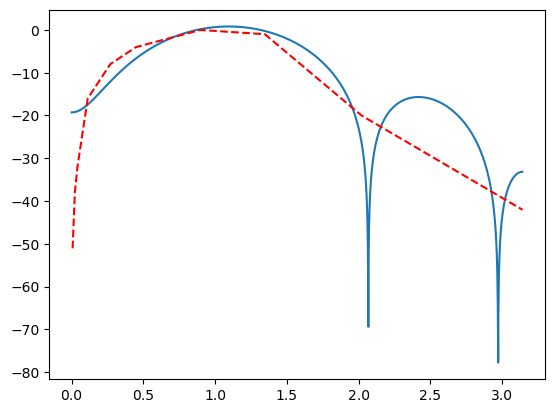

In [14]:
from scipy.signal import freqz

w, H = freqz(coefs, worN=2000)
plt.plot(w, 20*np.log10(np.abs(H)))
plt.plot(freqs, 20*np.log10(amps + 1e-10), 'r--')  # желаемая
plt.show()

Пример 1: Генерация массива с шагом 10 Гц
Размер массива частот: (996,)
Диапазон частот: 50 - 10000 Гц
Шаг: 10 Гц
Первые 5 значений коэффициента передачи: [0.02238721 0.03226849 0.04427169 0.05853632 0.07520149]
Последние 5 значений коэффициента передачи: [1.03844413e-05 1.02866281e-05 1.01899618e-05 1.00944249e-05
 1.00000000e-05]

Пример 2: Применение фильтра к белому шуму
Мощность исходного шума: 0.250444
Мощность отфильтрованного шума: 0.035016
Ослабление мощности: 8.54 дБ

Пример 3: Построение графиков АЧХ


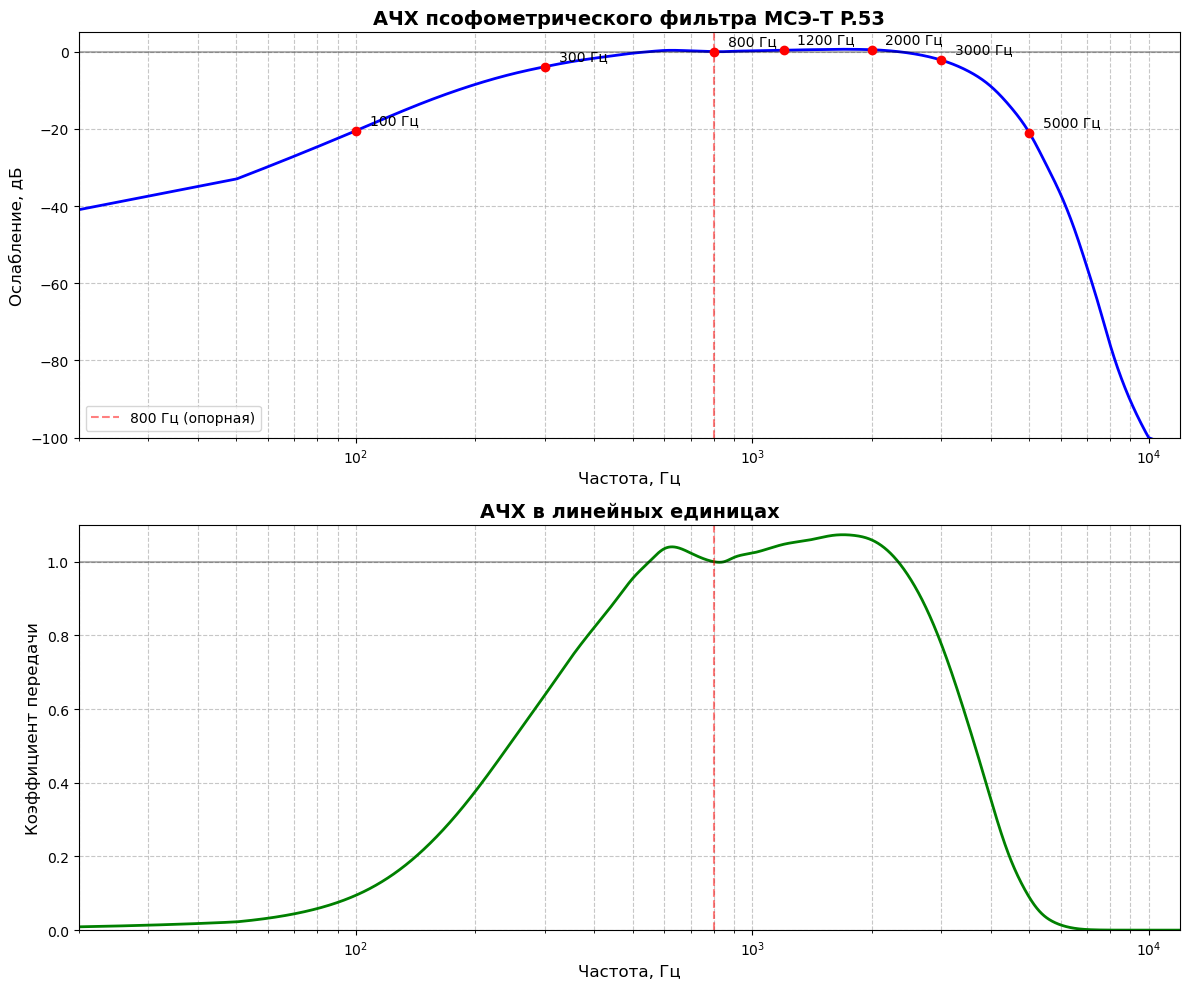


Таблица значений АЧХ псофометрического фильтра МСЭ-Т P.53
Частота, Гц  Ослабление, дБ     Коэффициент передачи
------------------------------------------------------------
50           -33.0000           0.022387            
100          -20.5000           0.094406            
200          -8.5000            0.375837            
300          -3.9000            0.638263            
400          -1.7000            0.822243            
500          -0.4000            0.954993            
600          0.3000             1.035142            
700          0.2000             1.023293            
800          -0.0000            1.000000            
900          0.1000             1.011579            
1000         0.2000             1.023293            
1200         0.4000             1.047129            
1400         0.5000             1.059254            
1600         0.6000             1.071519            
1800         0.6000             1.071519            
2000         0.5000             

In [ ]:
from scipy import interpolate

def psophometric_filter_response_mcut_p53(frequencies_hz):
    """
    Генерирует АЧХ псофометрического фильтра МСЭ-Т P.53 для заданных частот.
    
    Параметры:
    ----------
    frequencies_hz : numpy.ndarray
        Массив частот в герцах, для которых нужно рассчитать АЧХ
        
    Возвращает:
    -----------
    response_db : numpy.ndarray
        Массив значений АЧХ в дБ (относительно 800 Гц)
    response_linear : numpy.ndarray
        Массив значений АЧХ в линейных единицах (коэффициент передачи)
    """
    
    # Опорные точки АЧХ по МСЭ-Т P.53 (частоты в Гц, ослабление в дБ)
    # Ослабление отрицательное ниже 800 Гц, положительное в области пика
    reference_freqs = np.array([
        0,      50,    100,    150,    200,    250,    300,    350,
        400,    450,    500,    550,    600,    700,    800,    850,
        900,    1000,   1200,   1400,   1600,   1800,   2000,   2500,
        3000,   3500,   4000,   4500,   5000,   5500,   6000,   6500,
        7000,   7500,   8000,   10000,  20000,  50000,  100000
    ])
    
    reference_att_db = np.array([
        -np.inf, -33.0, -20.5, -13.0, -8.5,  -5.7,  -3.9,  -2.6,
        -1.7,   -1.0,   -0.4,   0.0,  +0.3,  +0.2,   0.0,   0.0,
        +0.1,   +0.2,   +0.4,   +0.5,  +0.6,  +0.6,  +0.5,  -0.4,
        -2.2,   -5.0,   -9.0,  -14.5, -21.0, -29.0, -37.0, -46.0,
        -56.0,  -66.0,  -76.0, -100.0, -140.0, -180.0, -200.0
    ])
    
    # Заменяем -inf на очень большое отрицательное значение для интерполяции
    reference_att_db_finite = reference_att_db.copy()
    reference_att_db_finite[0] = -200.0  # Для 0 Гц
    
    # Создаем интерполятор кубическими сплайнами (логарифмическая шкала частот)
    # Логарифмическая шкала лучше для аудиочастот
    log_freqs = np.log10(np.maximum(reference_freqs[1:], 1e-10))
    log_att = reference_att_db_finite[1:]
    
    # Для частот от 0 до 50 Гц используем линейную экстраполяцию в логарифмической шкале
    # Создаем интерполятор для всех точек
    interp_spline = interpolate.CubicSpline(
        np.log10(np.maximum(reference_freqs, 1e-10)), 
        reference_att_db_finite,
        extrapolate=True
    )
    
    # Вычисляем значения для входного массива частот
    response_db = interp_spline(np.log10(np.maximum(frequencies_hz, 1e-10)))
    
    # Для частот ниже 50 Гц применяем дополнительное затухание
    # Более резкий спад на очень низких частотах
    mask_low = frequencies_hz < 50
    if np.any(mask_low):
        # Экспоненциальный рост затухания ниже 50 Гц
        att_low = -33.0 - 20 * np.log10(50 / np.maximum(frequencies_hz[mask_low], 0.1))
        response_db[mask_low] = att_low
    
    # Для частот выше 10000 Гц - более резкий спад
    mask_high = frequencies_hz > 10000
    if np.any(mask_high):
        # Дополнительное затухание 12 дБ/октава выше 10 кГц
        att_high = -100.0 - 40 * np.log10(frequencies_hz[mask_high] / 10000)
        response_db[mask_high] = att_high
    
    # Преобразуем в линейные единицы (коэффициент передачи)
    response_linear = 10 ** (response_db / 20)
    
    return response_db, response_linear


def generate_psophometric_array(start_freq=50, end_freq=10000, step=1, return_type='both'):
    """
    Генерирует массив значений АЧХ псофометрического фильтра с заданным шагом.
    
    Параметры:
    ----------
    start_freq : float
        Начальная частота в Гц (по умолчанию 50)
    end_freq : float
        Конечная частота в Гц (по умолчанию 10000)
    step : float
        Шаг частот в Гц (по умолчанию 1)
    return_type : str
        Что возвращать: 'db' - только дБ, 'linear' - только линейные,
        'both' - оба массива и частоты (по умолчанию 'both')
        
    Возвращает:
    -----------
    В зависимости от return_type:
    - 'both': (freqs, response_db, response_linear)
    - 'db': (freqs, response_db)
    - 'linear': (freqs, response_linear)
    """
    # Создаем массив частот с заданным шагом
    freqs = np.arange(start_freq, end_freq + step, step)
    
    # Получаем АЧХ
    response_db, response_linear = psophometric_filter_response_mcut_p53(freqs)
    
    if return_type == 'db':
        return freqs, response_db
    elif return_type == 'linear':
        return freqs, response_linear
    else:  # 'both'
        return freqs, response_db, response_linear


def plot_psophometric_response():
    """Визуализация АЧХ псофометрического фильтра."""
    
    # Генерируем данные с мелким шагом для гладкого графика
    freqs, response_db, response_linear = generate_psophometric_array(
        start_freq=20, end_freq=12000, step=0.1, return_type='both'
    )
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # График в дБ
    ax1.semilogx(freqs, response_db, 'b-', linewidth=2)
    ax1.set_xlabel('Частота, Гц', fontsize=12)
    ax1.set_ylabel('Ослабление, дБ', fontsize=12)
    ax1.set_title('АЧХ псофометрического фильтра МСЭ-Т P.53', fontsize=14, fontweight='bold')
    ax1.grid(True, which='both', linestyle='--', alpha=0.7)
    ax1.set_xlim(20, 12000)
    ax1.set_ylim(-100, 5)
    ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax1.axvline(x=800, color='r', linestyle='--', alpha=0.5, label='800 Гц (опорная)')
    ax1.legend()
    
    # Отметим ключевые частоты
    key_freqs = [100, 300, 800, 1200, 2000, 3000, 5000]
    for f in key_freqs:
        idx = np.argmin(np.abs(freqs - f))
        ax1.plot(f, response_db[idx], 'ro', markersize=6)
        ax1.annotate(f'{f} Гц', (f, response_db[idx]), 
                    xytext=(10, 5), textcoords='offset points')
    
    # График в линейных единицах
    ax2.semilogx(freqs, response_linear, 'g-', linewidth=2)
    ax2.set_xlabel('Частота, Гц', fontsize=12)
    ax2.set_ylabel('Коэффициент передачи', fontsize=12)
    ax2.set_title('АЧХ в линейных единицах', fontsize=14, fontweight='bold')
    ax2.grid(True, which='both', linestyle='--', alpha=0.7)
    ax2.set_xlim(20, 12000)
    ax2.set_ylim(0, 1.1)
    ax2.axhline(y=1.0, color='k', linestyle='-', alpha=0.3)
    ax2.axvline(x=800, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Выводим таблицу значений для ключевых частот
    print("\n" + "="*60)
    print("Таблица значений АЧХ псофометрического фильтра МСЭ-Т P.53")
    print("="*60)
    print(f"{'Частота, Гц':<12} {'Ослабление, дБ':<18} {'Коэффициент передачи':<20}")
    print("-"*60)
    
    table_freqs = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 
                   1000, 1200, 1400, 1600, 1800, 2000, 2500, 3000, 
                   4000, 5000, 6000, 8000, 10000]
    
    for f in table_freqs:
        idx = np.argmin(np.abs(freqs - f))
        att_db = response_db[idx]
        k_linear = response_linear[idx]
        print(f"{f:<12} {att_db:<18.4f} {k_linear:<20.6f}")
    
    print("="*60)


def plot_psophometric_response_sbrn():
    """Визуализация АЧХ псофометрического фильтра."""
    
    # Генерируем данные с мелким шагом для гладкого графика
    freqs, response_db, response_linear = generate_psophometric_array(
        start_freq=20, end_freq=12000, step=0.1, return_type='both'
    )
    
    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    # График в дБ
    axes[0, 0].semilogx(freqs, response_db, 'b-', linewidth=2)
    axes[0, 0].set_title('АЧХ псофометрического фильтра МСЭ-Т P.53')
    axes[0, 0].set_xlabel('Частота, Гц')
    axes[0, 0].set_ylabel('Ослабление, дБ')
    #axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].grid(True, which='both', linestyle='--', alpha=0.7)
    axes[0, 0].set_xlim(20, 12000)
    axes[0, 0].set_ylim(-100, 5)
    axes[0, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    axes[0, 0].axvline(x=800, color='r', linestyle='--', alpha=0.5, label='800 Гц (опорная)')
    axes[0, 0].legend()

    # График в дБ
    #ax1.semilogx(freqs, response_db, 'b-', linewidth=2)
    #ax1.set_xlabel('Частота, Гц', fontsize=12)
    #ax1.set_ylabel('Ослабление, дБ', fontsize=12)
    #ax1.set_title('АЧХ псофометрического фильтра МСЭ-Т P.53', fontsize=14, fontweight='bold')
    ##ax1.grid(True, which='both', linestyle='--', alpha=0.7)
    #ax1.set_xlim(20, 12000)
    #ax1.set_ylim(-100, 5)
    #ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    #ax1.axvline(x=800, color='r', linestyle='--', alpha=0.5, label='800 Гц (опорная)')
    #ax1.legend()
    
    # Отметим ключевые частоты
    #key_freqs = [100, 300, 800, 1200, 2000, 3000, 5000]
    #for f in key_freqs:
    #    idx = np.argmin(np.abs(freqs - f))
    #    ax1.plot(f, response_db[idx], 'ro', markersize=6)
    #    ax1.annotate(f'{f} Гц', (f, response_db[idx]), 
    #                xytext=(10, 5), textcoords='offset points')
    
    # График в линейных единицах
    #ax2.semilogx(freqs, response_linear, 'g-', linewidth=2)
    #ax2.set_xlabel('Частота, Гц', fontsize=12)
    #ax2.set_ylabel('Коэффициент передачи', fontsize=12)
    #ax2.set_title('АЧХ в линейных единицах', fontsize=14, fontweight='bold')
    #ax2.grid(True, which='both', linestyle='--', alpha=0.7)
    #ax2.set_xlim(20, 12000)
    #ax2.set_ylim(0, 1.1)
    #ax2.axhline(y=1.0, color='k', linestyle='-', alpha=0.3)
    #ax2.axvline(x=800, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Выводим таблицу значений для ключевых частот
    print("\n" + "="*60)
    print("Таблица значений АЧХ псофометрического фильтра МСЭ-Т P.53")
    print("="*60)
    print(f"{'Частота, Гц':<12} {'Ослабление, дБ':<18} {'Коэффициент передачи':<20}")
    print("-"*60)
    
    table_freqs = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 
                   1000, 1200, 1400, 1600, 1800, 2000, 2500, 3000, 
                   4000, 5000, 6000, 8000, 10000]
    
    for f in table_freqs:
        idx = np.argmin(np.abs(freqs - f))
        att_db = response_db[idx]
        k_linear = response_linear[idx]
        print(f"{f:<12} {att_db:<18.4f} {k_linear:<20.6f}")
    
    print("="*60)

# Пример использования:
if __name__ == "__main__":
    # Пример 1: Получить массив значений с шагом 10 Гц
    print("Пример 1: Генерация массива с шагом 10 Гц")
    freqs, att_db, k_linear = generate_psophometric_array(
        start_freq=50, end_freq=10000, step=10, return_type='both'
    )
    
    print(f"Размер массива частот: {freqs.shape}")
    print(f"Диапазон частот: {freqs[0]} - {freqs[-1]} Гц")
    print(f"Шаг: {freqs[1] - freqs[0]} Гц")
    print(f"Первые 5 значений коэффициента передачи: {k_linear[:5]}")
    print(f"Последние 5 значений коэффициента передачи: {k_linear[-5:]}")
    
    # Пример 2: Использование в расчётах (фильтрация сигнала)
    print("\n" + "="*60)
    print("Пример 2: Применение фильтра к белому шуму")
    
    # Создаем тестовый сигнал (белый шум)
    fs = 44100  # Частота дискретизации
    duration = 1.0  # Длительность в секундах
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    
    # Белый шум
    np.random.seed(42)
    noise = np.random.randn(len(t)) * 0.5
    
    # Создаем частотную характеристику фильтра для всех частот ДПФ
    freqs_fft = np.fft.rfftfreq(len(noise), 1/fs)
    _, filter_response = psophometric_filter_response_mcut_p53(freqs_fft)
    
    # Применяем фильтр в частотной области
    noise_fft = np.fft.rfft(noise)
    noise_filtered_fft = noise_fft * filter_response
    noise_filtered = np.fft.irfft(noise_filtered_fft, n=len(noise))
    
    print(f"Мощность исходного шума: {np.mean(noise**2):.6f}")
    print(f"Мощность отфильтрованного шума: {np.mean(noise_filtered**2):.6f}")
    print(f"Ослабление мощности: {-10*np.log10(np.mean(noise_filtered**2)/np.mean(noise**2)):.2f} дБ")
    
    # Пример 3: Визуализация
    print("\n" + "="*60)
    print("Пример 3: Построение графиков АЧХ")
    plot_psophometric_response()

NameError: name 'report' is not defined

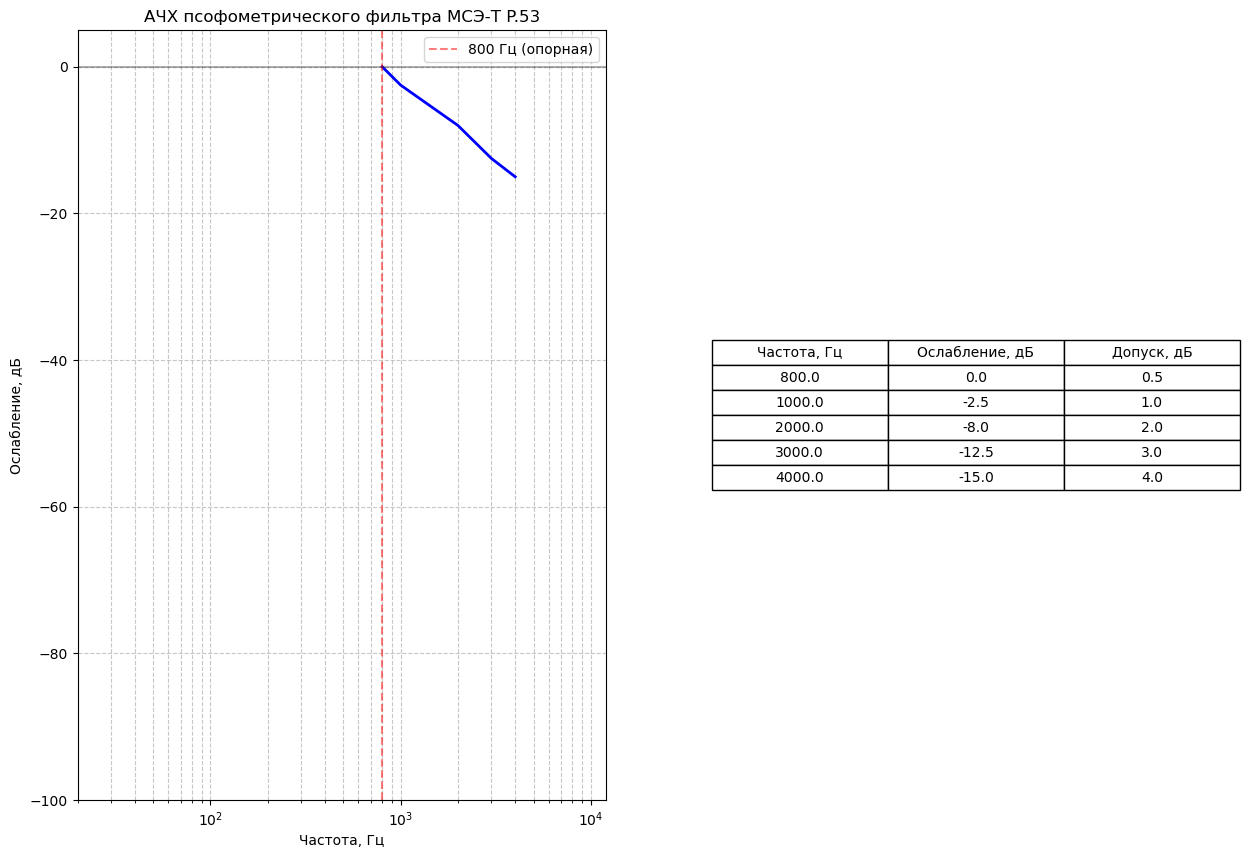

In [8]:
# Предположим, у вас есть 3 массива с данными для таблицы
# Например:
freq_points = np.array([800, 1000, 2000, 3000, 4000])  # частоты
response_vals = np.array([0, -2.5, -8.0, -12.5, -15.0])  # ослабление, дБ
tolerance = np.array([0.5, 1.0, 2.0, 3.0, 4.0])  # допуски

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# График в дБ
axes[0].semilogx(freq_points, response_vals, 'b-', linewidth=2)
axes[0].set_title('АЧХ псофометрического фильтра МСЭ-Т P.53')
axes[0].set_xlabel('Частота, Гц')
axes[0].set_ylabel('Ослабление, дБ')
axes[0].grid(True, which='both', linestyle='--', alpha=0.7)
axes[0].set_xlim(20, 12000)
axes[0].set_ylim(-100, 5)
axes[0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[0].axvline(x=800, color='r', linestyle='--', alpha=0.5, label='800 Гц (опорная)')
axes[0].legend()

# Таблица во второй ячейке
# Подготавливаем данные для таблицы
table_data = np.column_stack((freq_points, response_vals, tolerance))
columns = ('Частота, Гц', 'Ослабление, дБ', 'Допуск, дБ')

# Создаем таблицу
table = axes[1].table(cellText=table_data,
                      colLabels=columns,
                      loc='center',
                      cellLoc='center')


table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Масштабирование

# Отключаем оси для таблицы
axes[1].axis('off')
axes[1].text(0, 0, report, fontsize=10, family='monospace')
axes[1].set_title('Характеристики фильтра')

plt.tight_layout()
plt.show()

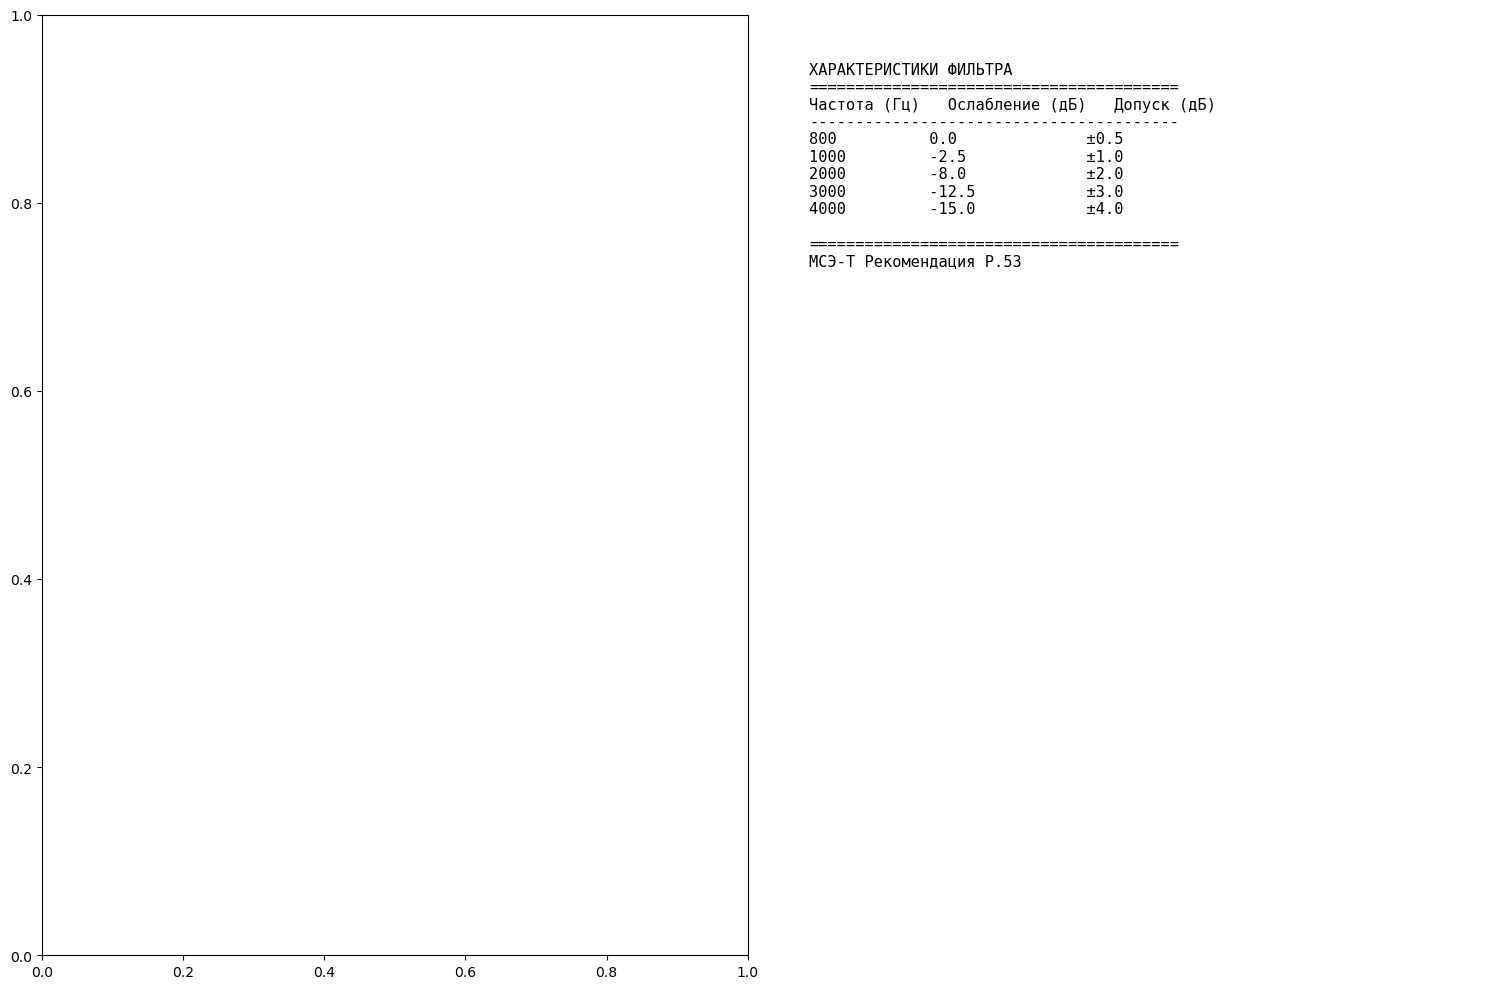

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Ваши данные
freq_points = np.array([800, 1000, 2000, 3000, 4000])
response_vals = np.array([0, -2.5, -8.0, -12.5, -15.0])
tolerance = np.array(['±0.5', '±1.0', '±2.0', '±3.0', '±4.0'])

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# График (используем axes[0])
# ... ваш код для графика ...

# Таблица в текстовом виде
axes[1].axis('off')

# Форматируем таблицу как текст
table_text = "ХАРАКТЕРИСТИКИ ФИЛЬТРА\n"
table_text += "=" * 40 + "\n"
table_text += "Частота (Гц)   Ослабление (дБ)   Допуск (дБ)\n"
table_text += "-" * 40 + "\n"

for i in range(len(freq_points)):
    table_text += f"{freq_points[i]:<12} {response_vals[i]:<16.1f} {tolerance[i]:<12}\n"

# Добавляем подпись
table_text += "\n" + "=" * 40 + "\n"
table_text += "МСЭ-Т Рекомендация P.53"

# Выводим текст
axes[1].text(0.05, 0.95, table_text, 
             fontsize=11, 
             family='monospace',
             verticalalignment='top',
             transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

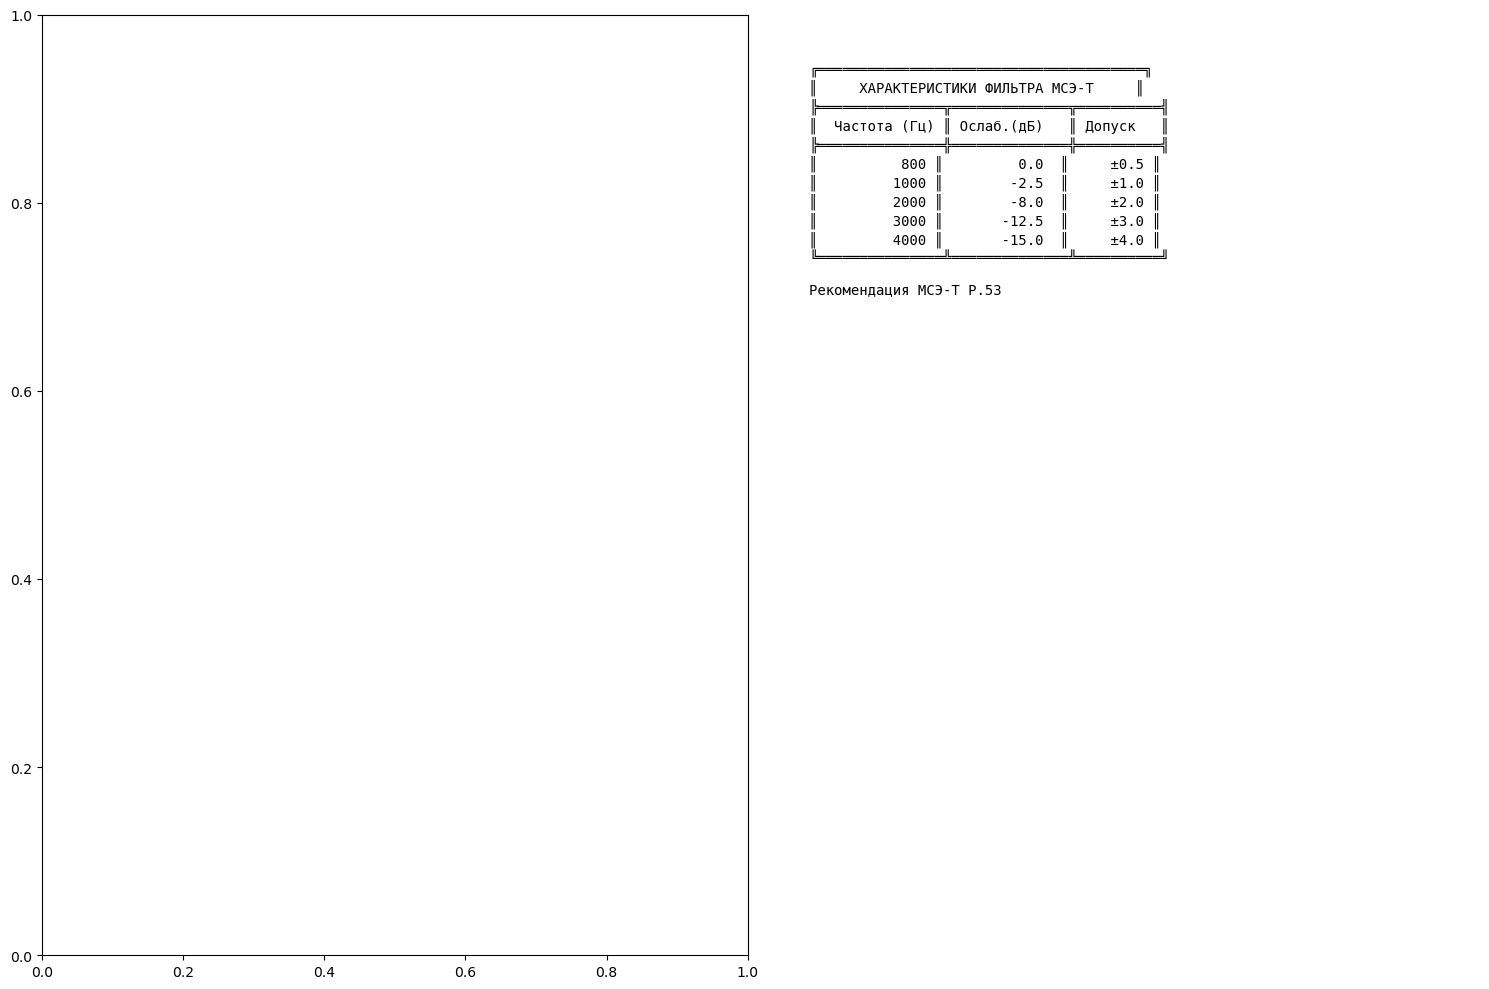

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Ваши данные
freq_points = np.array([800, 1000, 2000, 3000, 4000])
response_vals = np.array([0, -2.5, -8.0, -12.5, -15.0])
tolerance = np.array(['±0.5', '±1.0', '±2.0', '±3.0', '±4.0'])

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# График (используем axes[0])
# ... ваш код для графика ...

axes[1].axis('off')

# Создаем красиво отформатированную таблицу
table_text = "╔═══════════════════════════════════════╗\n"
table_text += "║     ХАРАКТЕРИСТИКИ ФИЛЬТРА МСЭ-Т     ║\n"
table_text += "╠═══════════════╦══════════════╦══════════╣\n"
table_text += "║  Частота (Гц) ║ Ослаб.(дБ)   ║ Допуск   ║\n"
table_text += "╠═══════════════╬══════════════╬══════════╣\n"

for i in range(len(freq_points)):
    table_text += f"║ {freq_points[i]:>12} ║ {response_vals[i]:>11.1f}  ║ {tolerance[i]:>8} ║\n"

table_text += "╚═══════════════╩══════════════╩══════════╝\n"
table_text += "\nРекомендация МСЭ-Т P.53"

axes[1].text(0.05, 0.95, table_text, 
             fontsize=10, 
             family='monospace',
             verticalalignment='top',
             transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

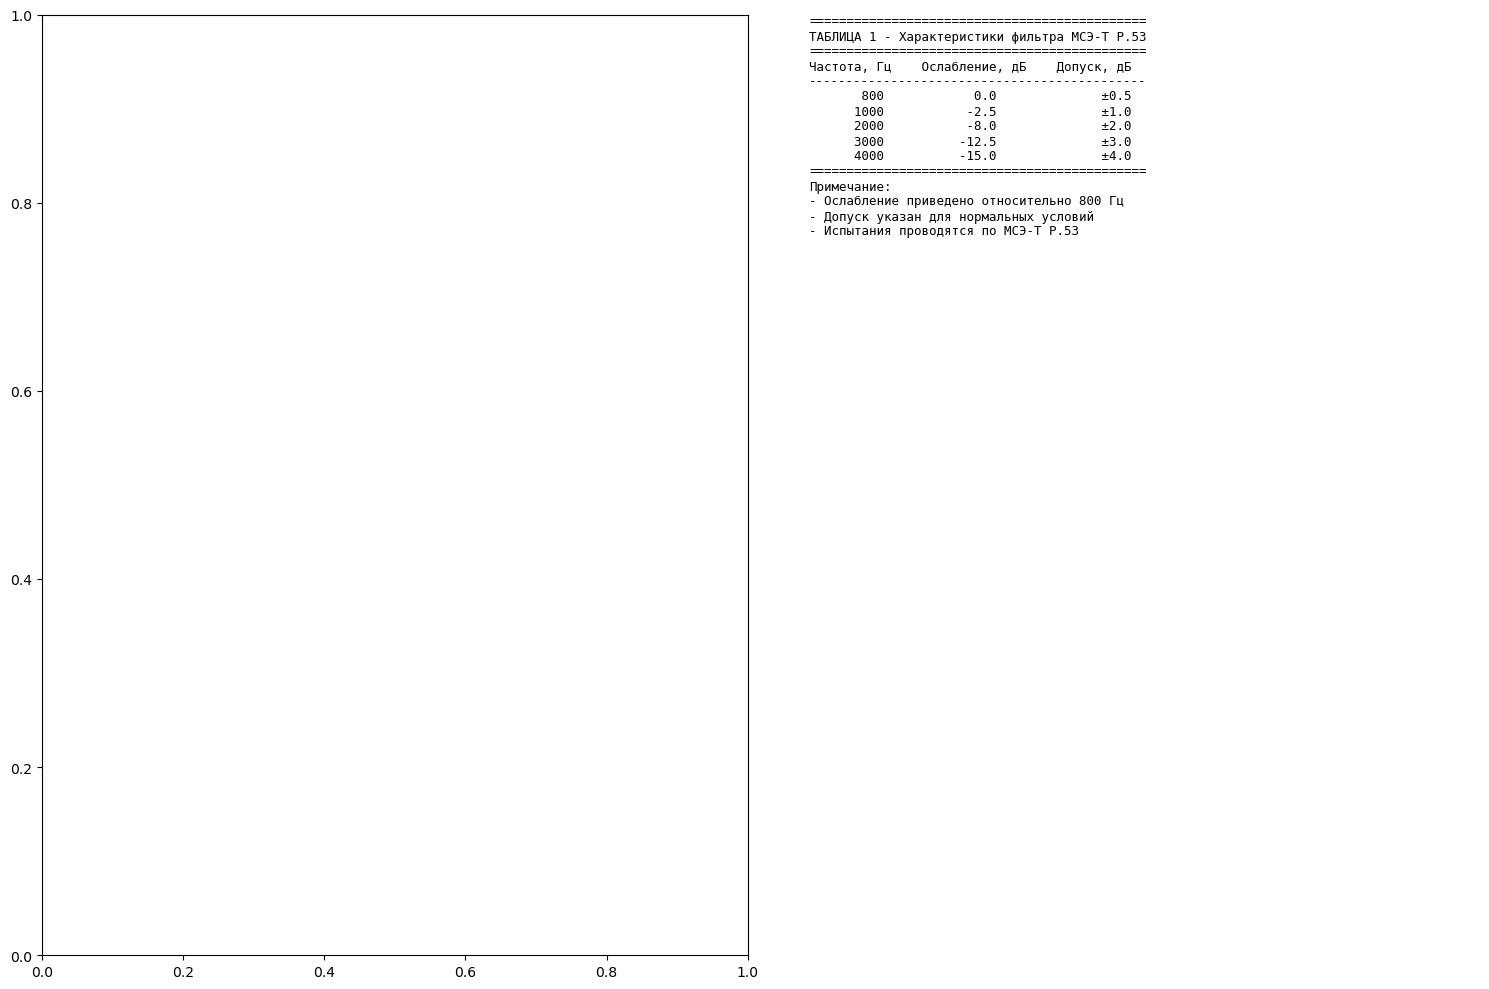

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Ваши данные
freq_points = np.array([800, 1000, 2000, 3000, 4000])
response_vals = np.array([0, -2.5, -8.0, -12.5, -15.0])
tolerance = np.array(['±0.5', '±1.0', '±2.0', '±3.0', '±4.0'])

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# График (используем axes[0])
# ... ваш код для графика ...

axes[1].axis('off')

# Форматирование с выравниванием по правому краю для чисел
table_text = ""
table_text += "=" * 45 + "\n"
table_text += "ТАБЛИЦА 1 - Характеристики фильтра МСЭ-Т P.53\n"
table_text += "=" * 45 + "\n"
table_text += "Частота, Гц    Ослабление, дБ    Допуск, дБ\n"
table_text += "-" * 45 + "\n"

for i in range(len(freq_points)):
    # Выравнивание: частота - по правому краю, ослабление - по центру
    table_text += f"{freq_points[i]:>10}      {response_vals[i]:>9.1f}        {tolerance[i]:>10}\n"

table_text += "=" * 45

# Можно добавить примечание
note = "\nПримечание:\n"
note += "- Ослабление приведено относительно 800 Гц\n"
note += "- Допуск указан для нормальных условий\n"
note += "- Испытания проводятся по МСЭ-Т P.53"

axes[1].text(0.05, 1.0, table_text + note, 
             fontsize=9, 
             family='monospace',
             verticalalignment='top',
             transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

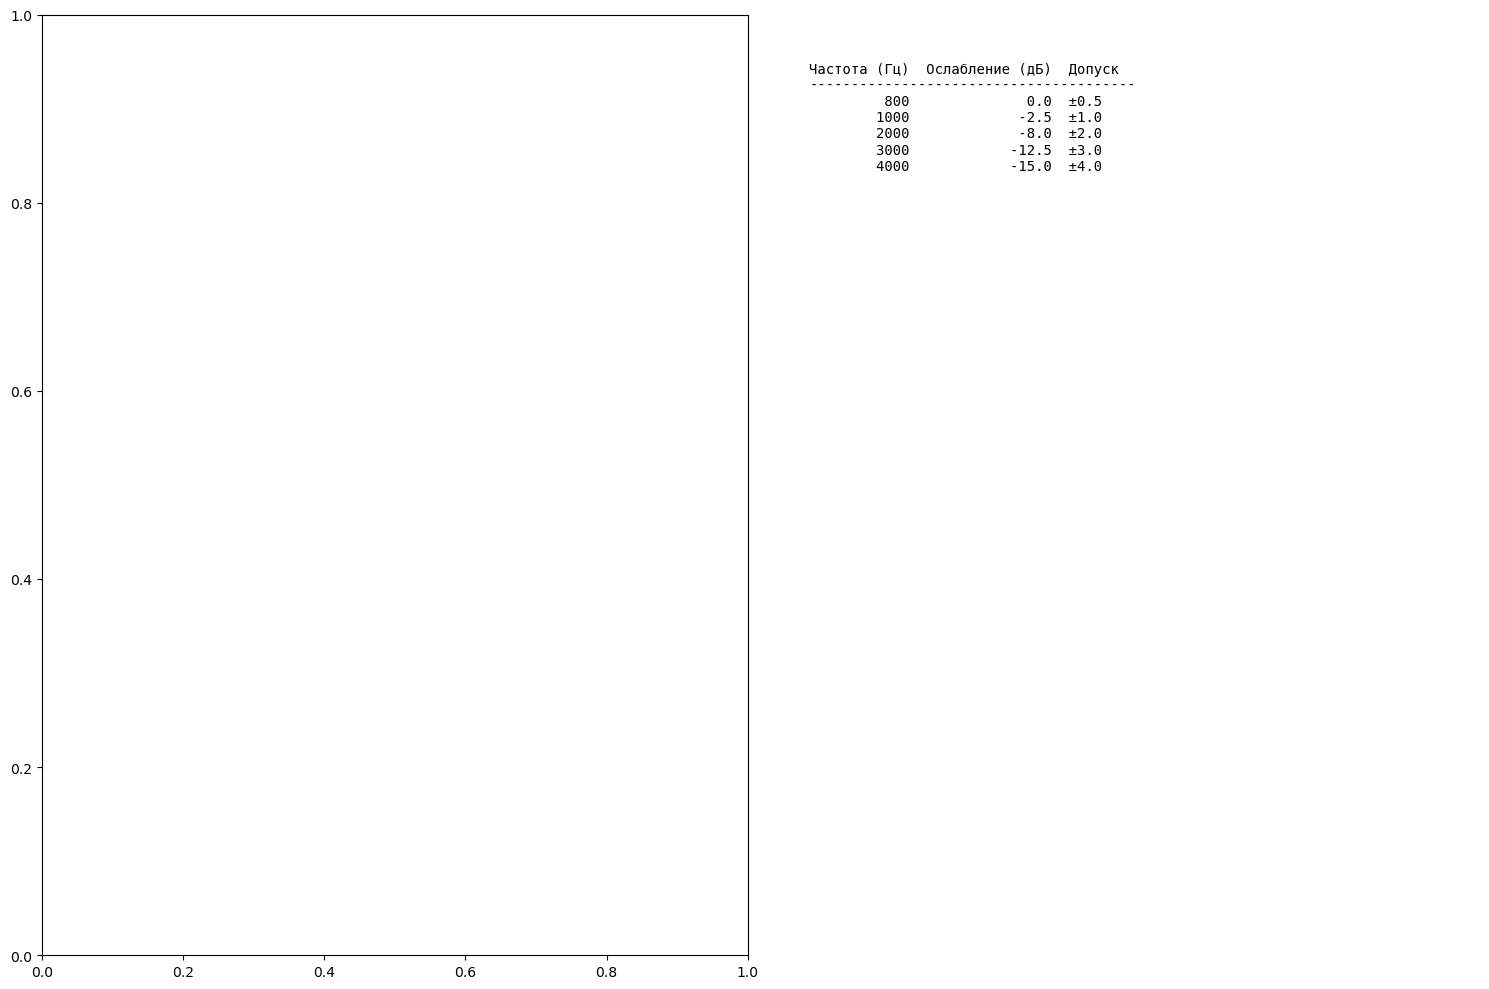

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Ваши данные
freq_points = np.array([800, 1000, 2000, 3000, 4000])
response_vals = np.array([0, -2.5, -8.0, -12.5, -15.0])
tolerance = np.array(['±0.5', '±1.0', '±2.0', '±3.0', '±4.0'])

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# График (используем axes[0])
# ... ваш код для графика ...
axes[1].axis('off')

# Автоматическое форматирование
data = []
for i in range(len(freq_points)):
    data.append([str(freq_points[i]), 
                 f"{response_vals[i]:.1f}", 
                 tolerance[i]])

# Определяем максимальную ширину для каждого столбца
col_widths = [0, 0, 0]
for row in data:
    for j in range(3):
        col_widths[j] = max(col_widths[j], len(row[j]))

# Добавляем заголовки
headers = ["Частота (Гц)", "Ослабление (дБ)", "Допуск"]
for j in range(3):
    col_widths[j] = max(col_widths[j], len(headers[j]))

# Создаем таблицу
table_text = ""
# Заголовки
for j in range(3):
    table_text += f"{headers[j]:<{col_widths[j]}}  "
table_text += "\n"
table_text += "-" * (sum(col_widths) + 6) + "\n"

# Данные
for row in data:
    for j in range(3):
        # Для числовых данных выравниваем по правому краю
        if j in [0, 1]:
            table_text += f"{row[j]:>{col_widths[j]}}  "
        else:
            table_text += f"{row[j]:<{col_widths[j]}}  "
    table_text += "\n"

axes[1].text(0.05, 0.95, table_text, 
             fontsize=10, 
             family='monospace',
             verticalalignment='top',
             transform=axes[1].transAxes)

plt.tight_layout()
plt.show()